In [8]:
import pandas as pd
import numpy as np
import torch
import itertools
import seaborn as sns
import pickle
import matplotlib.pyplot as plt

#from pathos.pools import ProcessPool
from sklearn.metrics import pairwise
from tqdm import tqdm
from scipy.spatial.distance import jensenshannon

from lin_alg_utils import compute_mat_W_X
from kernel_density_ratio import get_bandwidth, kde_ratio_estimator
from KRR_estimators import (
    inner_prod_MCE_split, inner_prod_MCE_full, inner_prod_QMCE_split, inner_prod_QMCE_full,
    inner_prod_QMCE_asymp, inner_prod_QMCE_CV
)
from ece_kde import get_bandwidth, get_ece_kde
from simulations import (
    ground_truth_sim, inner_prod_estimator_simulation, inner_prod_CV_simulation,
    inner_prod_temp_simulation, inner_prod_estimator_kde_simulation, inner_prod_CV_simulation_alt,
    inner_prod_estimator_simple_simulation, inner_prod_estimator_cond_simulation, dir_noise_term,
    ce_estimator_simulation, ce_estimator_lin_simulation, ce_const_simulation
)

In [273]:
seed = 0
n_classes = 100
# we pick alpha such that the average max prob is ~0.9
dir_alpha = 0.002
temp = 1
n_XY = 5
n_UV = 10
np.random.seed(seed)
Xs = np.random.dirichlet(alpha=np.repeat(dir_alpha, n_classes), size=n_XY)
X_primes = np.random.dirichlet(alpha=np.repeat(dir_alpha, n_classes), size=n_XY)
Us = np.random.dirichlet(alpha=np.repeat(dir_alpha, n_classes), size=n_UV)
Ys = np.array([np.random.choice(n_classes, p=X**temp/np.sum(X**temp)) for X in Xs])
Vs = np.array([np.random.choice(n_classes, p=U**temp/np.sum(U**temp)) for U in Us])
print('Freq of 1s in K_YU', delta_kernel(Ys, Vs).mean())
print('Avg conf:', Xs.max(1).mean())

Freq of 1s in K_YU 0.0
Avg conf: 0.9764257413637931


In [165]:
reg_const = .01
MCE_est = inner_prod_MCE(Ys, Xs, Vs, Us, reg_const=reg_const)
print(MCE_est)
QMCE_est = inner_prod_QMCE(Ys, Xs, Vs, Us, reg_const=reg_const**2)
print(QMCE_est)

0.1678946933963071
0.3337653881410306


In [92]:
ground_truth_sim(Xs, Us, temp=0.5)

0.7403244509108547

In [ ]:
seeds = range(10)
data_size = 1000
p_true = (0.01, 0.05, 0.14, 0.8)
estimates = np.arange(0, 1, 0.05)
exp_results = inner_prod_estimator_simple_simulation(seeds, data_size, p_true, estimates)

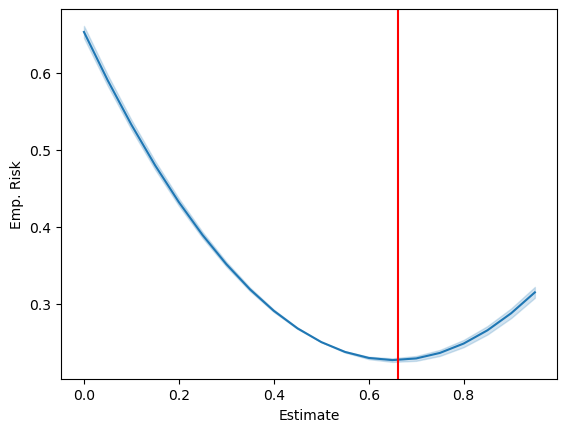

In [12]:
g = sns.lineplot(data=exp_results, x='Estimate', y='Emp. Risk', errorbar='sd')
g.axvline(x = np.linalg.norm(p_true)**2, ymin = 0, ymax = 1, color='red')
g.get_figure();

In [9]:
seeds = range(20)
data_size = 500
n_classes = 5
dir_alpha = 0.04
T_estimates = 2**np.arange(-5, 5, 0.05)
exp_results = inner_prod_estimator_cond_simulation(seeds, dir_alpha, n_classes, data_size, T_estimates)

100%|███████████████████████████████████████████| 20/20 [03:06<00:00,  9.31s/it]


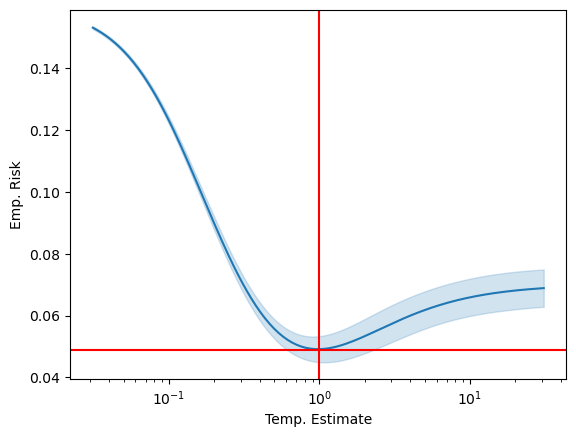

In [10]:
g = sns.lineplot(data=exp_results, x='Temp. Estimate', y='Emp. Risk', errorbar='sd')
g.set(xscale = 'log')
g.axvline(x = 1, ymin = 0, ymax = 1, color='red')
g.axhline(y = dir_noise_term(dir_alpha=0.04, n_classes=5), xmin = 0, xmax = 1, color='red')
g.get_figure();

In [6]:
seeds = range(100)
data_size = 500
n_classes = 5
dir_alpha = 0.04
T_estimates = 2**np.arange(-5, 5, 0.05)
exp_results = inner_prod_estimator_cond_lin_simulation(seeds, dir_alpha, n_classes, data_size, T_estimates)

100%|█████████████████████████████████████████| 100/100 [00:17<00:00,  5.73it/s]


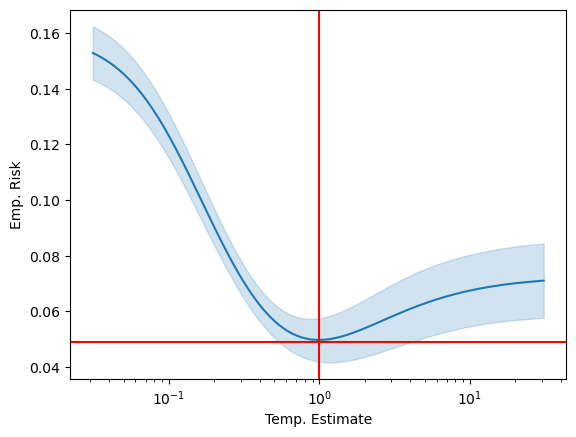

In [7]:
g = sns.lineplot(data=exp_results, x='Temp. Estimate', y='Emp. Risk', errorbar='sd')
g.set(xscale = 'log')
g.axvline(x = 1, ymin = 0, ymax = 1, color='red')
g.axhline(y = dir_noise_term(dir_alpha=0.04, n_classes=5), xmin = 0, xmax = 1, color='red')
g.get_figure();

In [6]:
seeds = range(100)
data_size = 500
n_classes = 5
dir_alpha = 0.04
T_estimates = 2**np.arange(-5, 5, 0.05)
exp_results = ce_estimator_simulation(seeds, dir_alpha, n_classes, data_size, T_estimates, temp=.3)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:50<00:00,  1.98it/s]


/tmp/ipykernel_3480746/2989112356.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g.set_xticklabels(g.get_xticklabels(), rotation=30)


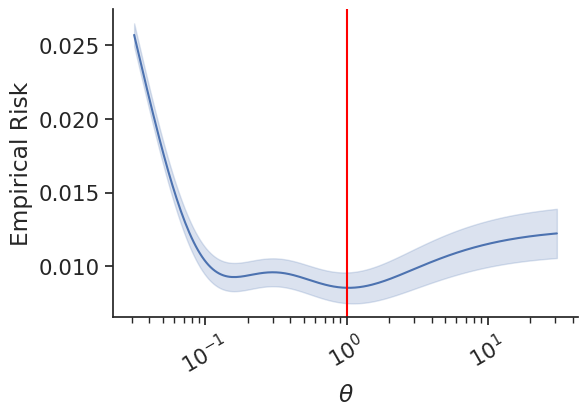

In [10]:
sns.set(font_scale=1.4)
sns.set_style('ticks')
plt.figure(figsize=(6, 4))

g = sns.lineplot(data=exp_results, x='Temp. Estimate', y='Emp. Risk', errorbar='sd')
g.set(xscale = 'log')
g.axvline(x = 1, ymin = 0, ymax = 1, color='red')
g.set(ylabel='Empirical Risk', xlabel='$\\theta$')
g.set_xticklabels(g.get_xticklabels(), rotation=30)
sns.despine()
#g.axhline(y = dir_noise_term(dir_alpha=0.04, n_classes=5), xmin = 0, xmax = 1, color='red')
g.get_figure().savefig("Plots/ce_est_sim_t=.3.png", bbox_inches='tight');

In [37]:
seeds = range(100)
data_size = 500
p_true_1 = np.array([0.01, 0.05, 0.14, 0.8])
p_true_2 = np.array([0.11, 0.7, 0.05, 0.14])
p_1 = np.array([0.8, 0.05, 0.01, 0.14])
p_2 = np.array([0.01, 0.05, 0.8, 0.14])
estimates = np.arange(-0.5, 0.5, 0.025)
temp = 2
exp_results = ce_const_simulation(seeds, data_size, estimates, p_true_1, p_true_2, p_1=p_1, p_2=p_2)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 63.37it/s]


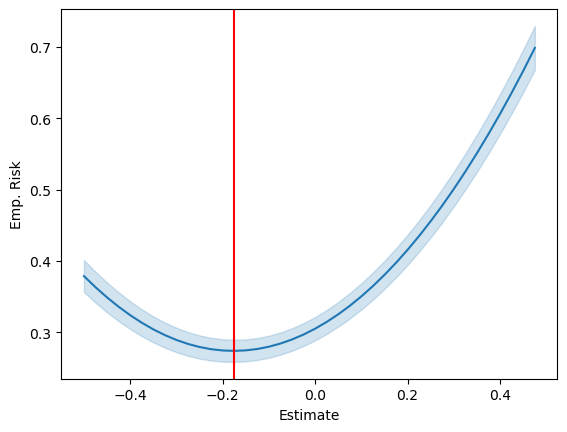

In [38]:
g = sns.lineplot(data=exp_results, x='Estimate', y='Emp. Risk', errorbar='sd')
#g.set(xscale = 'log')
g.axvline(x = np.inner(p_true_1-p_1, p_true_2-p_2), ymin = 0, ymax = 1, color='red')
#g.axhline(y = dir_noise_term(dir_alpha=0.04, n_classes=5), xmin = 0, xmax = 1, color='red')
g.get_figure().savefig("Plots/ce_const_sim_t=2.png");